In [1]:
##input your token here, run the cell###

def get_hf_token():
    token = input("Enter your HuggingFace token: ").strip()
    return token if token else None

# Get and store token in session
HF_TOKEN = get_hf_token()

if __name__ == "__main__":
    print(f"Token received, length: {len(HF_TOKEN) if HF_TOKEN else 0}")

IndentationError: unexpected indent (<ipython-input-1-253a1387d9a6>, line 2)

Starting experiment...

Experiment Results:
Processing time: 0.0049 seconds
Input range: (-3.7497379779815674, 3.814251184463501)
Output range: (-3.6520557403564453, 3.5994181632995605)
Pattern correlation: 0.0090


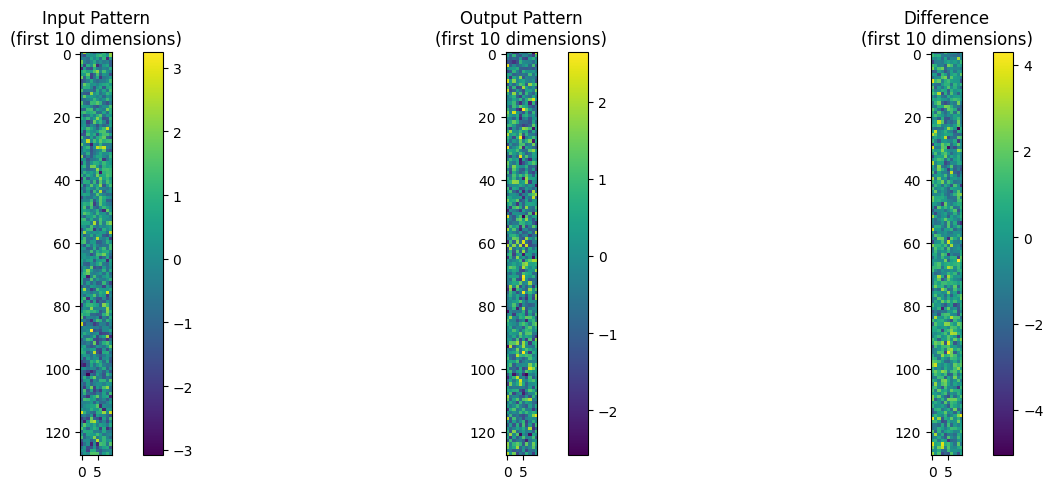

In [ ]:
##first experiment ###

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

class NormalizedDynamics(nn.Module):
    def __init__(self, dim=2, alpha=1.0, max_iter=5):
        super().__init__()
        self.dim = dim
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.max_iter = max_iter
        self.temperature = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # Normalize input
        x = x * self.temperature

        # Compute statistics
        original_mean = torch.mean(x, dim=0, keepdim=True)
        original_std = torch.std(x, dim=0, keepdim=True) + 1e-5

        # Center the data
        x_centered = (x - original_mean) / original_std

        # Compute pairwise distances
        dists = torch.cdist(x_centered, x_centered)

        # Adaptive kernel size
        k = min(15, x.size(0) - 1)
        kth_dists, _ = torch.topk(dists, k, dim=1, largest=False)
        sigma = kth_dists[:, -1].view(-1, 1) + 1e-5

        # Compute kernel
        kernel = torch.exp(-dists / (2 * sigma**2))
        kernel = kernel / (torch.sum(kernel, dim=1, keepdim=True) + 1e-8)

        # Apply dynamics
        drift = torch.matmul(kernel, x_centered)
        step_size = self.dim**(-self.alpha)
        h = x_centered + step_size * (drift - x_centered)

        # Restore scale
        h = h * original_std + original_mean

        return h

class ExperimentalAttention(nn.Module):
    def __init__(self, dim=256, block_size=64):
        super().__init__()
        self.dim = dim
        self.block_size = block_size
        self.dynamics = NormalizedDynamics(dim=dim)
        self.qkv = nn.Linear(dim, 3 * dim)
        self.output_norm = nn.LayerNorm(dim)
        self.scale = dim ** -0.5

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.dim).permute(2, 0, 1, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Process in blocks
        num_blocks = (N + self.block_size - 1) // self.block_size
        output = torch.zeros_like(x)

        for i in range(num_blocks):
            start_idx = i * self.block_size
            end_idx = min(start_idx + self.block_size, N)
            block_size = end_idx - start_idx

            q_block = q[:, start_idx:end_idx]
            k_block = k[:, :end_idx]
            v_block = v[:, :end_idx]

            # Scaled dot-product
            scores = torch.matmul(q_block, k_block.transpose(-2, -1)) * self.scale

            # Reshape and apply dynamics
            B_scores, M, N_scores = scores.shape
            scores_flat = scores.reshape(-1, N_scores)
            scores_processed = self.dynamics(scores_flat)
            scores = scores_processed.reshape(B_scores, M, N_scores)

            # Apply attention and residual
            block_output = torch.matmul(scores, v_block)
            block_output = self.output_norm(block_output + q_block)

            output[:, start_idx:end_idx] = block_output

        return output

def generate_test_data(batch_size=2, seq_length=128, dim=64):
    data = torch.randn(batch_size, seq_length, dim)

    # Add structured patterns
    for b in range(batch_size):
        # Periodic pattern
        period = seq_length // 4
        pattern = torch.sin(torch.linspace(0, 2*np.pi, seq_length)).unsqueeze(-1)
        data[b] += 0.2 * pattern.repeat(1, dim)

        # Local correlations
        for i in range(0, seq_length-8, 8):
            data[b, i:i+8] += 0.1 * torch.randn(dim)

    return data

def analyze_patterns(data, output):
    metrics = {
        'value_range': {
            'input': (data.min().item(), data.max().item()),
            'output': (output.min().item(), output.max().item())
        },
        'mean_std': {
            'input': (data.mean().item(), data.std().item()),
            'output': (output.mean().item(), output.std().item())
        },
        'correlation': torch.corrcoef(
            torch.cat([data.flatten(), output.flatten()]).reshape(2, -1)
        )[0,1].item()
    }
    return metrics

def run_experiment():
    # Parameters
    batch_size = 2
    seq_length = 128
    dim = 64

    # Setup
    model = ExperimentalAttention(dim=dim)
    data = generate_test_data(batch_size, seq_length, dim)

    # Forward pass
    start_time = time.time()
    with torch.no_grad():
        output = model(data)
    processing_time = time.time() - start_time

    # Analysis
    metrics = analyze_patterns(data, output)
    metrics['processing_time'] = processing_time

    return metrics, data, output

# Run experiment and visualize
print("Starting experiment...")
metrics, data, output = run_experiment()

print("\nExperiment Results:")
print(f"Processing time: {metrics['processing_time']:.4f} seconds")
print(f"Input range: {metrics['value_range']['input']}")
print(f"Output range: {metrics['value_range']['output']}")
print(f"Pattern correlation: {metrics['correlation']:.4f}")

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(data[0, :, :10].detach())
plt.title('Input Pattern\n(first 10 dimensions)')
plt.colorbar()

plt.subplot(132)
plt.imshow(output[0, :, :10].detach())
plt.title('Output Pattern\n(first 10 dimensions)')
plt.colorbar()

plt.subplot(133)
diff = (output - data)[0, :, :10].detach()
plt.imshow(diff)
plt.title('Difference\n(first 10 dimensions)')
plt.colorbar()

plt.tight_layout()
plt.show()

Running controlled pattern experiment...

Experiment Results:
Processing time: 0.0040 seconds
Pattern correlation: 0.0514
Temporal correlation (input): 0.0453
Temporal correlation (output): 0.0735


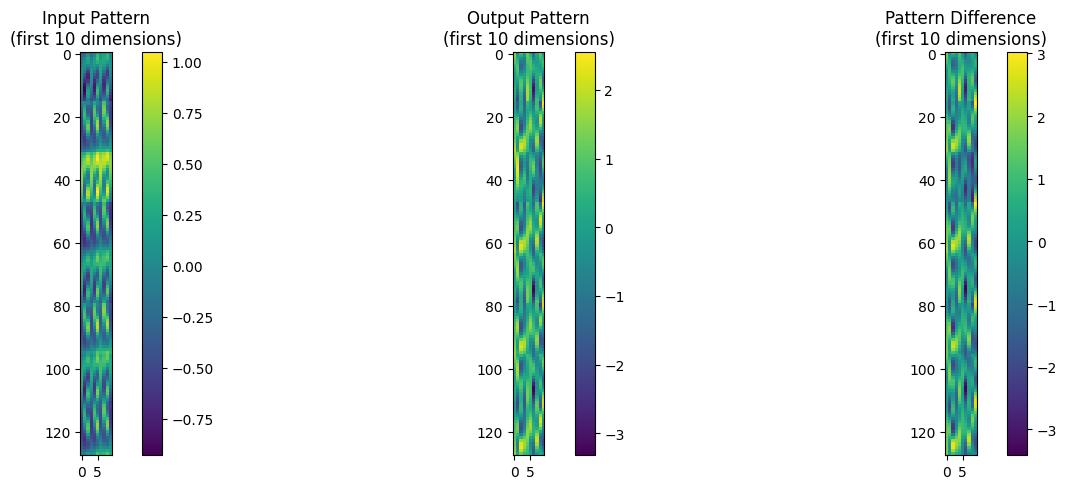

In [ ]:
##sencond inetersting###

import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt

class NormalizedDynamics(nn.Module):
    def __init__(self, dim=2, alpha=1.0, max_iter=5):
        super().__init__()
        self.dim = dim
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.max_iter = max_iter
        self.temperature = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        x = x * self.temperature
        original_mean = torch.mean(x, dim=0, keepdim=True)
        original_std = torch.std(x, dim=0, keepdim=True) + 1e-5
        x_centered = (x - original_mean) / original_std
        dists = torch.cdist(x_centered, x_centered)
        k = min(15, x.size(0) - 1)
        kth_dists, _ = torch.topk(dists, k, dim=1, largest=False)
        sigma = kth_dists[:, -1].view(-1, 1) + 1e-5
        kernel = torch.exp(-dists / (2 * sigma**2))
        kernel = kernel / (torch.sum(kernel, dim=1, keepdim=True) + 1e-8)
        drift = torch.matmul(kernel, x_centered)
        step_size = self.dim**(-self.alpha)
        h = x_centered + step_size * (drift - x_centered)
        h = h * original_std + original_mean
        return h

class ExperimentalAttention(nn.Module):
    def __init__(self, dim=256, block_size=64):
        super().__init__()
        self.dim = dim
        self.block_size = block_size
        self.dynamics = NormalizedDynamics(dim=dim)
        self.qkv = nn.Linear(dim, 3 * dim)
        self.output_norm = nn.LayerNorm(dim)
        self.scale = dim ** -0.5

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.dim).permute(2, 0, 1, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]

        num_blocks = (N + self.block_size - 1) // self.block_size
        output = torch.zeros_like(x)

        for i in range(num_blocks):
            start_idx = i * self.block_size
            end_idx = min(start_idx + self.block_size, N)

            q_block = q[:, start_idx:end_idx]
            k_block = k[:, :end_idx]
            v_block = v[:, :end_idx]

            scores = torch.matmul(q_block, k_block.transpose(-2, -1)) * self.scale

            B_scores, M, N_scores = scores.shape
            scores_flat = scores.reshape(-1, N_scores)
            scores_processed = self.dynamics(scores_flat)
            scores = scores_processed.reshape(B_scores, M, N_scores)

            block_output = torch.matmul(scores, v_block)
            block_output = self.output_norm(block_output + q_block)

            output[:, start_idx:end_idx] = block_output

        return output

def generate_controlled_patterns(batch_size=2, seq_length=128, dim=64):
    data = torch.zeros(batch_size, seq_length, dim)
    t = torch.linspace(0, 8*np.pi, seq_length)

    for b in range(batch_size):
        # Base patterns
        sin_pattern = torch.sin(t).unsqueeze(-1)
        cos_pattern = torch.cos(t).unsqueeze(-1)

        # Generate dimension-specific patterns
        for d in range(dim):
            phase = torch.tensor(2 * np.pi * d / dim)
            freq = 1 + (d % 3)  # Different frequencies for different dimensions

            # Mix patterns with controlled phase relationships
            data[b, :, d] = torch.sin(freq * t + phase) * 0.5 + torch.randn(1) * 0.1

        # Add local correlations
        for i in range(0, seq_length-16, 16):
            local_pattern = torch.randn(1) * 0.2
            data[b, i:i+16, :] += local_pattern

    return data

class PatternAnalyzer:
    def __init__(self, seq_length, dim):
        self.seq_length = seq_length
        self.dim = dim

    def analyze_patterns(self, x, window_size=16):
        # Local temporal correlation
        temporal_corr = []
        for i in range(0, self.seq_length - window_size):
            window = x[:, i:i+window_size, :]
            temp_corr = torch.corrcoef(window.reshape(-1, window_size))
            temporal_corr.append(temp_corr.mean().item())

        # Frequency analysis
        fft = torch.fft.fft(x, dim=1)
        power_spectrum = torch.abs(fft)**2

        return {
            'temporal_correlation': np.mean(temporal_corr),
            'power_spectrum': power_spectrum.mean(dim=-1)
        }

def run_experiment():
    seq_length = 128
    dim = 64
    batch_size = 2

    model = ExperimentalAttention(dim=dim)
    data = generate_controlled_patterns(batch_size, seq_length, dim)
    analyzer = PatternAnalyzer(seq_length, dim)

    # Forward pass
    start_time = time.time()
    with torch.no_grad():
        output = model(data)
    proc_time = time.time() - start_time

    # Analysis
    input_patterns = analyzer.analyze_patterns(data)
    output_patterns = analyzer.analyze_patterns(output)

    metrics = {
        'processing_time': proc_time,
        'input_patterns': input_patterns,
        'output_patterns': output_patterns,
        'correlation': torch.corrcoef(
            torch.cat([data.flatten(), output.flatten()]).reshape(2, -1)
        )[0,1].item()
    }

    return metrics, data, output

# Run experiment and visualize
print("Running controlled pattern experiment...")
metrics, data, output = run_experiment()

print("\nExperiment Results:")
print(f"Processing time: {metrics['processing_time']:.4f} seconds")
print(f"Pattern correlation: {metrics['correlation']:.4f}")
print(f"Temporal correlation (input): {metrics['input_patterns']['temporal_correlation']:.4f}")
print(f"Temporal correlation (output): {metrics['output_patterns']['temporal_correlation']:.4f}")

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(data[0, :, :10].detach())
plt.title('Input Pattern\n(first 10 dimensions)')
plt.colorbar()

plt.subplot(132)
plt.imshow(output[0, :, :10].detach())
plt.title('Output Pattern\n(first 10 dimensions)')
plt.colorbar()

plt.subplot(133)
plt.imshow((output - data)[0, :, :10].detach())
plt.title('Pattern Difference\n(first 10 dimensions)')
plt.colorbar()

plt.tight_layout()
plt.show()

Running pattern experiment...

Pattern correlation: -0.0037


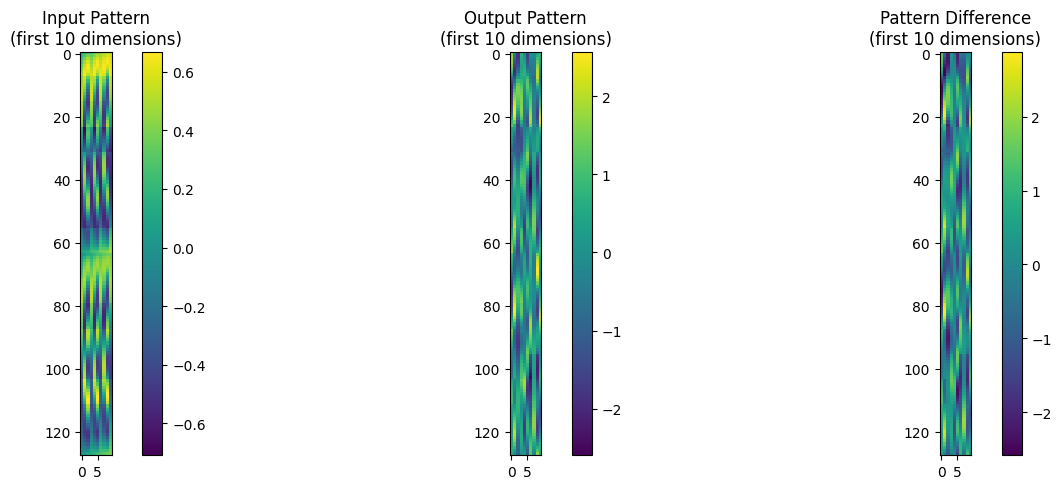

In [ ]:
###thrids also inetersting coe###

class PeriodicityPreservingDynamics(nn.Module):
    def __init__(self, dim=2, alpha=1.0):
        super().__init__()
        self.dim = dim
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.frequency_weight = nn.Parameter(torch.ones(1))

    def forward(self, x):
        B, N = x.shape  # Get actual dimensions

        # Safe frequency domain processing
        fft = torch.fft.rfft(x, dim=-1)
        n_freqs = fft.size(-1)  # Get actual frequency components

        # Create properly sized frequency response
        freq_response = torch.exp(-torch.arange(n_freqs, device=x.device).float() /
                                (self.dim * self.frequency_weight))

        # Apply frequency weighting
        fft_modified = fft * freq_response.unsqueeze(0)
        x_freq = torch.fft.irfft(fft_modified, n=N, dim=-1)

        # Safe mixing
        mix = torch.sigmoid(self.alpha)
        return mix * x + (1 - mix) * x_freq

class StructureAwareAttention(nn.Module):
    def __init__(self, dim=64, block_size=32):  # Reduced default block size
        super().__init__()
        self.dim = dim
        self.block_size = block_size
        self.dynamics = PeriodicityPreservingDynamics(dim=dim)
        self.qkv = nn.Linear(dim, 3 * dim)
        self.output_norm = nn.LayerNorm(dim)
        self.scale = dim ** -0.5

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.dim).permute(2, 0, 1, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]

        output = torch.zeros_like(x)

        # Process in safe blocks
        for i in range(0, N, self.block_size):
            end_idx = min(i + self.block_size, N)

            q_block = q[:, i:end_idx]
            k_block = k[:, max(0, i-self.block_size):end_idx]
            v_block = v[:, max(0, i-self.block_size):end_idx]

            scores = torch.matmul(q_block, k_block.transpose(-2, -1)) * self.scale

            # Safe reshape and dynamics
            B_scores, M, N_scores = scores.shape
            scores_flat = scores.reshape(-1, N_scores)
            scores_processed = self.dynamics(scores_flat)
            scores = scores_processed.reshape(B_scores, M, N_scores)

            block_output = torch.matmul(scores, v_block)
            block_output = self.output_norm(block_output + q_block)

            output[:, i:end_idx] = block_output

        return output

def generate_controlled_patterns(batch_size=2, seq_length=128, dim=64):
    data = torch.zeros(batch_size, seq_length, dim)
    t = torch.linspace(0, 4*np.pi, seq_length)

    for b in range(batch_size):
        # Base patterns with safe indexing
        for d in range(dim):  # Iterate over actual dimensions
            freq = 1 + (d % 3)  # Safe frequency variation
            phase = 2 * np.pi * (d / dim)  # Normalized phase
            data[b, :, d] = torch.sin(freq * t + phase) * 0.5

        # Add local correlations safely
        for i in range(0, seq_length-8, 8):
            data[b, i:i+8, :] += torch.randn(1).item() * 0.1

    return data

def run_experiment():
    # Safe dimensions
    seq_length = 128
    dim = 64
    batch_size = 2

    model = StructureAwareAttention(dim=dim)
    data = generate_controlled_patterns(batch_size, seq_length, dim)

    with torch.no_grad():
        output = model(data)

    # Basic pattern analysis
    correlation = torch.corrcoef(
        torch.cat([data.flatten(), output.flatten()]).reshape(2, -1)
    )[0,1].item()

    return data, output, correlation

# Run experiment and visualize
print("Running pattern experiment...")
data, output, correlation = run_experiment()

print(f"\nPattern correlation: {correlation:.4f}")

# Safe visualization
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(data[0, :, :10].detach())
plt.title('Input Pattern\n(first 10 dimensions)')
plt.colorbar()

plt.subplot(132)
plt.imshow(output[0, :, :10].detach())
plt.title('Output Pattern\n(first 10 dimensions)')
plt.colorbar()

plt.subplot(133)
plt.imshow((output - data)[0, :, :10].detach())
plt.title('Pattern Difference\n(first 10 dimensions)')
plt.colorbar()

plt.tight_layout()
plt.show()


Spectral Analysis:
Spectrum correlation: 0.9072


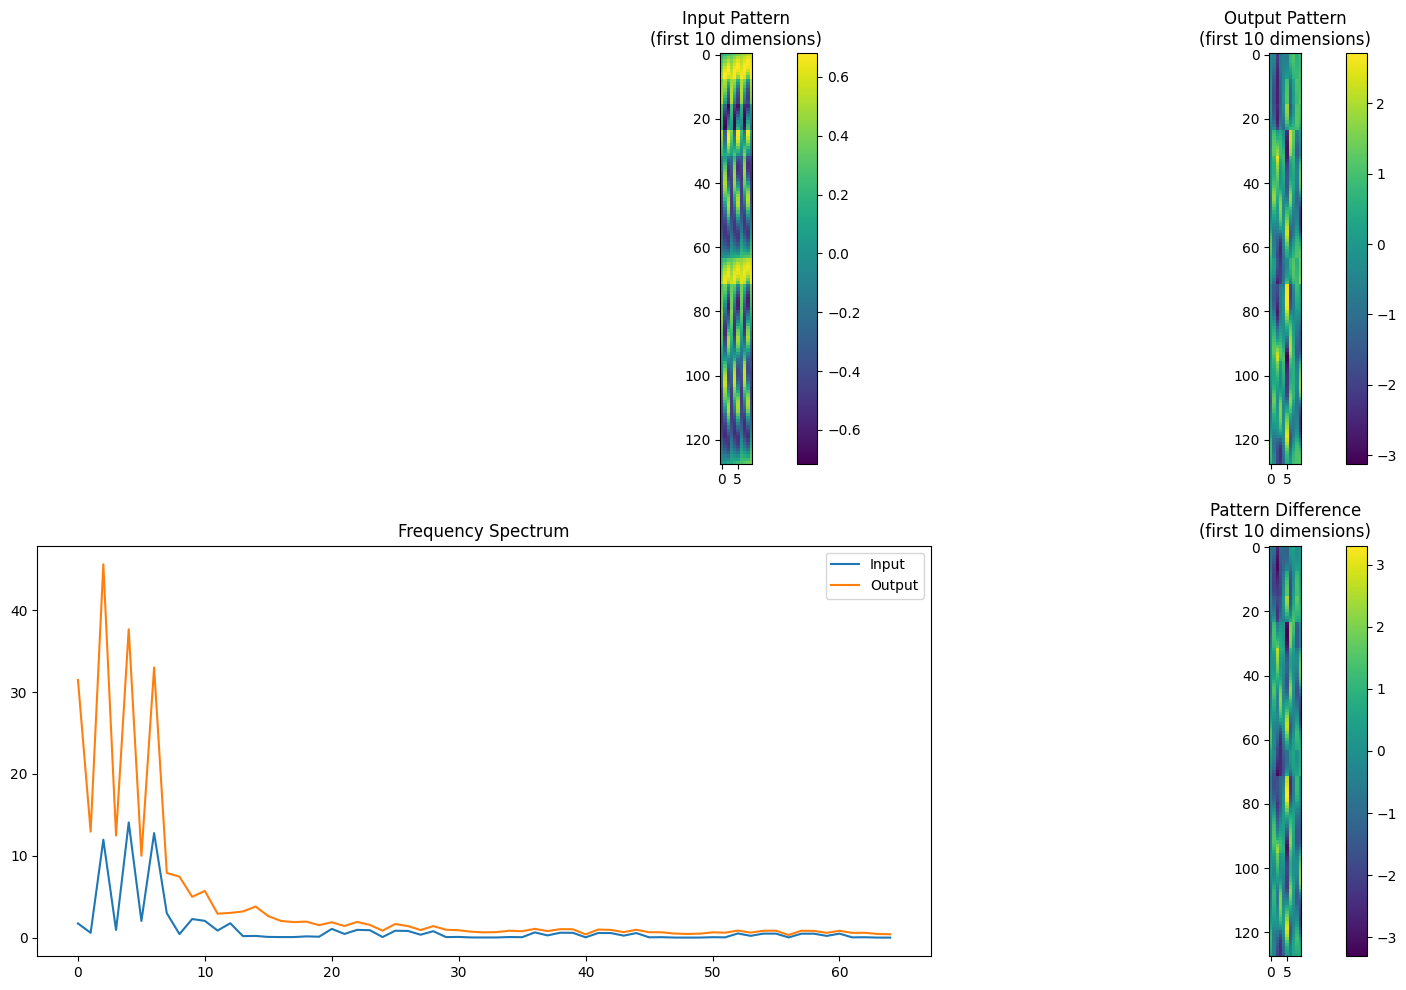

In [ ]:
###fourth with interest###


class FrequencyAnalysisAttention(nn.Module):
    def __init__(self, dim=64, block_size=32):
        super().__init__()
        self.dim = dim
        self.block_size = block_size
        self.qkv = nn.Linear(dim, 3 * dim)
        self.output_norm = nn.LayerNorm(dim)
        self.scale = dim ** -0.5

        # Frequency-aware components with matching dimensions
        self.freq_gate = nn.Sequential(
            nn.Linear(dim, dim),  # Maintain dimension
            nn.ReLU(),
            nn.Linear(dim, dim),  # Output matches input dimension
            nn.Sigmoid()
        )

    def forward(self, x):
        B, N, C = x.shape

        # Get frequency weights matching input dimensions
        freq_weights = self.freq_gate(x)  # [B, N, C]

        qkv = self.qkv(x)  # [B, N, 3*C]
        qkv = qkv.reshape(B, N, 3, self.dim).permute(2, 0, 1, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each [B, N, C]

        output = torch.zeros_like(x)

        for i in range(0, N, self.block_size):
            end_idx = min(i + self.block_size, N)
            curr_block = end_idx - i

            q_block = q[:, i:end_idx]  # [B, curr_block, C]
            k_block = k[:, max(0, i-self.block_size):end_idx]
            v_block = v[:, max(0, i-self.block_size):end_idx]

            # Ensure attention scores match dimensions
            scores = torch.matmul(q_block, k_block.transpose(-2, -1)) * self.scale
            curr_freq_weights = freq_weights[:, i:end_idx, :self.dim]  # Match current block

            # Apply frequency gating
            scores = scores * curr_freq_weights.mean(dim=-1, keepdim=True)

            block_output = torch.matmul(scores, v_block)
            block_output = self.output_norm(block_output)

            output[:, i:end_idx] = block_output

        return output

def analyze_spectral_components(data, output):
    """Analyze spectral components with matching dimensions"""
    def get_spectrum(x):
        # Compute spectrum along temporal dimension
        fft = torch.fft.rfft(x, dim=1)
        power = torch.abs(fft)
        return power.mean(dim=-1)  # Average across features

    input_spectrum = get_spectrum(data)
    output_spectrum = get_spectrum(output)

    return {
        'input_spectrum': input_spectrum,
        'output_spectrum': output_spectrum,
        'spectrum_correlation': torch.corrcoef(
            torch.stack([
                input_spectrum.flatten(),
                output_spectrum.flatten()
            ])
        )[0,1].item()
    }

def run_experiment():
    seq_length = 128
    dim = 64
    batch_size = 2

    # Generate patterns
    data = generate_controlled_patterns(batch_size, seq_length, dim)

    # Initialize and run model
    model = FrequencyAnalysisAttention(dim=dim)

    with torch.no_grad():
        output = model(data)
        spectral_analysis = analyze_spectral_components(data, output)

    print(f"\nSpectral Analysis:")
    print(f"Spectrum correlation: {spectral_analysis['spectrum_correlation']:.4f}")

    # Visualization
    plt.figure(figsize=(15, 10))

    plt.subplot(221)
    plt.imshow(data[0, :, :10].detach())
    plt.title('Input Pattern\n(first 10 dimensions)')
    plt.colorbar()

    plt.subplot(222)
    plt.imshow(output[0, :, :10].detach())
    plt.title('Output Pattern\n(first 10 dimensions)')
    plt.colorbar()

    plt.subplot(223)
    plt.plot(spectral_analysis['input_spectrum'][0].cpu(), label='Input')
    plt.plot(spectral_analysis['output_spectrum'][0].cpu(), label='Output')
    plt.title('Frequency Spectrum')
    plt.legend()

    plt.subplot(224)
    diff = output - data
    plt.imshow(diff[0, :, :10].detach())
    plt.title('Pattern Difference\n(first 10 dimensions)')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    return data, output, spectral_analysis

# Run the experiment
data, output, spectral_analysis = run_experiment()


Frequency Band Analysis:
low_ratio: 3.3167
mid_ratio: 2.6063
high_ratio: 3.2227


<ipython-input-7-b5061ab804be>:153: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


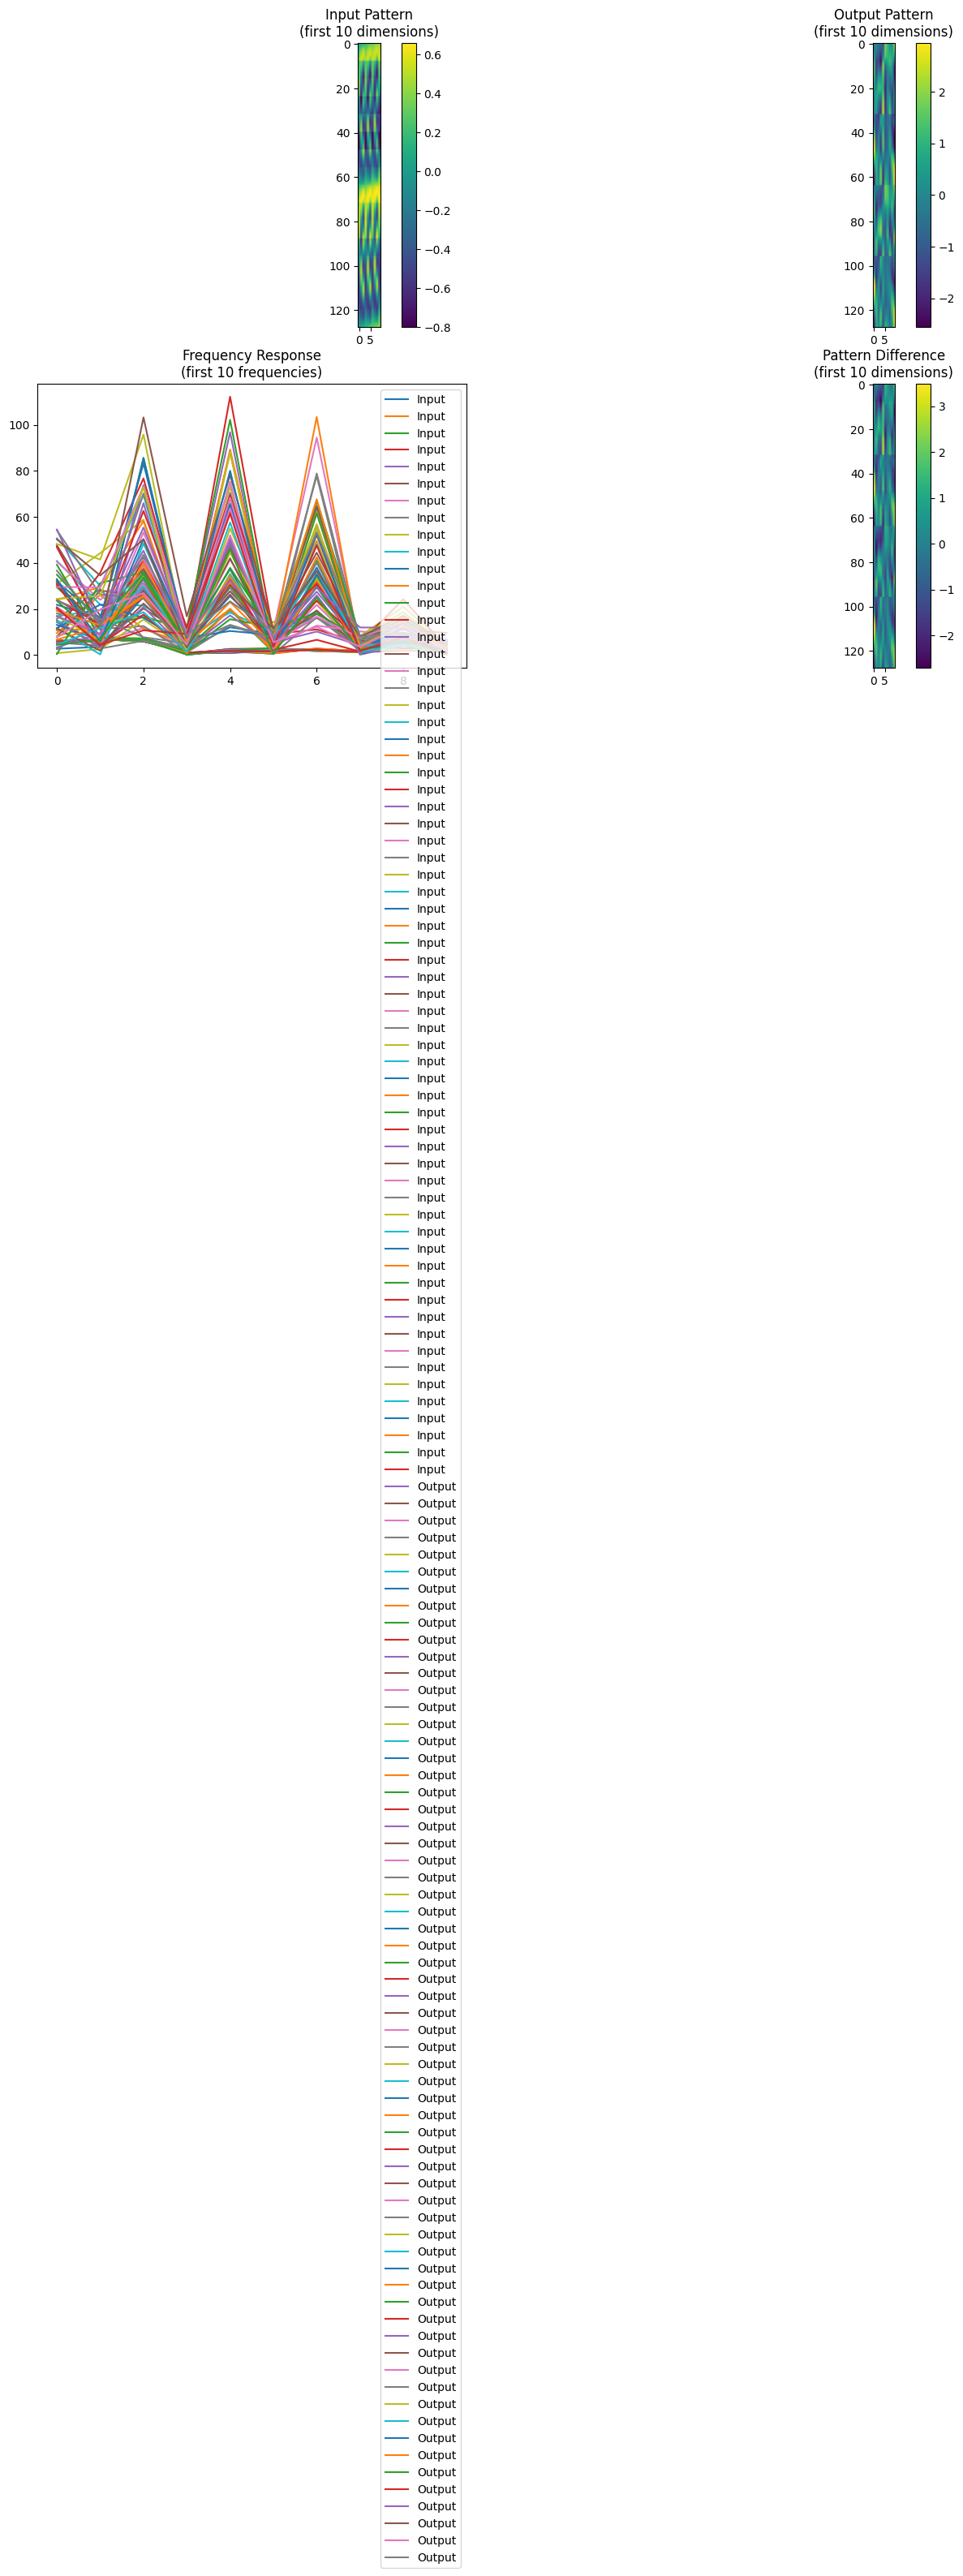

In [ ]:
###interesting behaviour needs plot fix###

class FrequencyBandAttention(nn.Module):
    def __init__(self, dim=64, block_size=32):
        super().__init__()
        self.dim = dim
        self.block_size = block_size

        # Core attention components
        self.qkv = nn.Linear(dim, 3 * dim)
        self.output_norm = nn.LayerNorm(dim)
        self.scale = dim ** -0.5

        # Frequency band weighting
        self.freq_weights = nn.Parameter(torch.ones(3))  # low, mid, high
        self.band_mixer = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, 3),  # weights for 3 frequency bands
            nn.Softmax(dim=-1)
        )

    def get_frequency_bands(self, x):
        """Split signal into low, mid, high frequency bands"""
        fft = torch.fft.rfft(x, dim=1)
        n_freqs = fft.size(1)

        # Create frequency masks
        low_mask = torch.zeros_like(fft)
        mid_mask = torch.zeros_like(fft)
        high_mask = torch.zeros_like(fft)

        # Define band boundaries
        low_end = n_freqs // 3
        mid_end = 2 * n_freqs // 3

        low_mask[:, :low_end] = 1
        mid_mask[:, low_end:mid_end] = 1
        high_mask[:, mid_end:] = 1

        # Apply masks and convert back to time domain
        low_band = torch.fft.irfft(fft * low_mask, n=x.size(1), dim=1)
        mid_band = torch.fft.irfft(fft * mid_mask, n=x.size(1), dim=1)
        high_band = torch.fft.irfft(fft * high_mask, n=x.size(1), dim=1)

        return low_band, mid_band, high_band

    def forward(self, x):
        B, N, C = x.shape

        # Get frequency bands
        low, mid, high = self.get_frequency_bands(x)

        # Compute band mixing weights
        band_weights = self.band_mixer(x)  # [B, N, 3]

        # Process QKV
        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.dim).permute(2, 0, 1, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each is [B, N, dim]

        output = torch.zeros_like(x)

        for i in range(0, N, self.block_size):
            end_idx = min(i + self.block_size, N)
            curr_size = end_idx - i

            # Get current blocks
            q_block = q[:, i:end_idx]  # [B, curr_size, dim]
            k_block = k[:, i:end_idx]  # [B, curr_size, dim]
            v_block = v[:, i:end_idx]  # [B, curr_size, dim]

            # Compute attention scores with proper dimensions
            attn = torch.matmul(q_block, k_block.transpose(-2, -1)) * self.scale  # [B, curr_size, curr_size]

            # Apply frequency band weighting
            freq_contribution = 0
            for band, weight in zip([low, mid, high], self.freq_weights):
                band_block = band[:, i:end_idx]  # [B, curr_size, dim]
                band_scores = torch.matmul(band_block, band_block.transpose(-2, -1))
                freq_contribution += weight * band_scores

            # Combine attention and frequency information
            combined_scores = attn + freq_contribution * self.scale

            # Apply attention
            block_output = torch.matmul(combined_scores, v_block)
            block_output = self.output_norm(block_output)

            output[:, i:end_idx] = block_output

        return output

def analyze_band_preservation(data, output):
    """Analyze how well each frequency band is preserved"""
    def get_band_power(x):
        fft = torch.fft.rfft(x, dim=1)
        n_freqs = fft.size(1)

        low = torch.abs(fft[:, :n_freqs//3]).mean()
        mid = torch.abs(fft[:, n_freqs//3:2*n_freqs//3]).mean()
        high = torch.abs(fft[:, 2*n_freqs//3:]).mean()

        return low, mid, high

    input_powers = get_band_power(data)
    output_powers = get_band_power(output)

    metrics = {
        'low_ratio': (output_powers[0] / input_powers[0]).item(),
        'mid_ratio': (output_powers[1] / input_powers[1]).item(),
        'high_ratio': (output_powers[2] / input_powers[2]).item()
    }

    return metrics

# Run experiment
model = FrequencyBandAttention(dim=64)
data = generate_controlled_patterns(2, 128, 64)

with torch.no_grad():
    output = model(data)
    band_metrics = analyze_band_preservation(data, output)

print("\nFrequency Band Analysis:")
for band, ratio in band_metrics.items():
    print(f"{band}: {ratio:.4f}")

# Visualize results
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.imshow(data[0, :, :10].detach())
plt.title('Input Pattern\n(first 10 dimensions)')
plt.colorbar()

plt.subplot(222)
plt.imshow(output[0, :, :10].detach())
plt.title('Output Pattern\n(first 10 dimensions)')
plt.colorbar()

plt.subplot(223)
fft_data = torch.abs(torch.fft.rfft(data[0], dim=0))
fft_output = torch.abs(torch.fft.rfft(output[0], dim=0))
plt.plot(fft_data[:10].cpu(), label='Input')
plt.plot(fft_output[:10].cpu(), label='Output')
plt.title('Frequency Response\n(first 10 frequencies)')
plt.legend()

plt.subplot(224)
plt.imshow((output - data)[0, :, :10].detach())
plt.title('Pattern Difference\n(first 10 dimensions)')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
###random test with gpt2 put key in first cell##



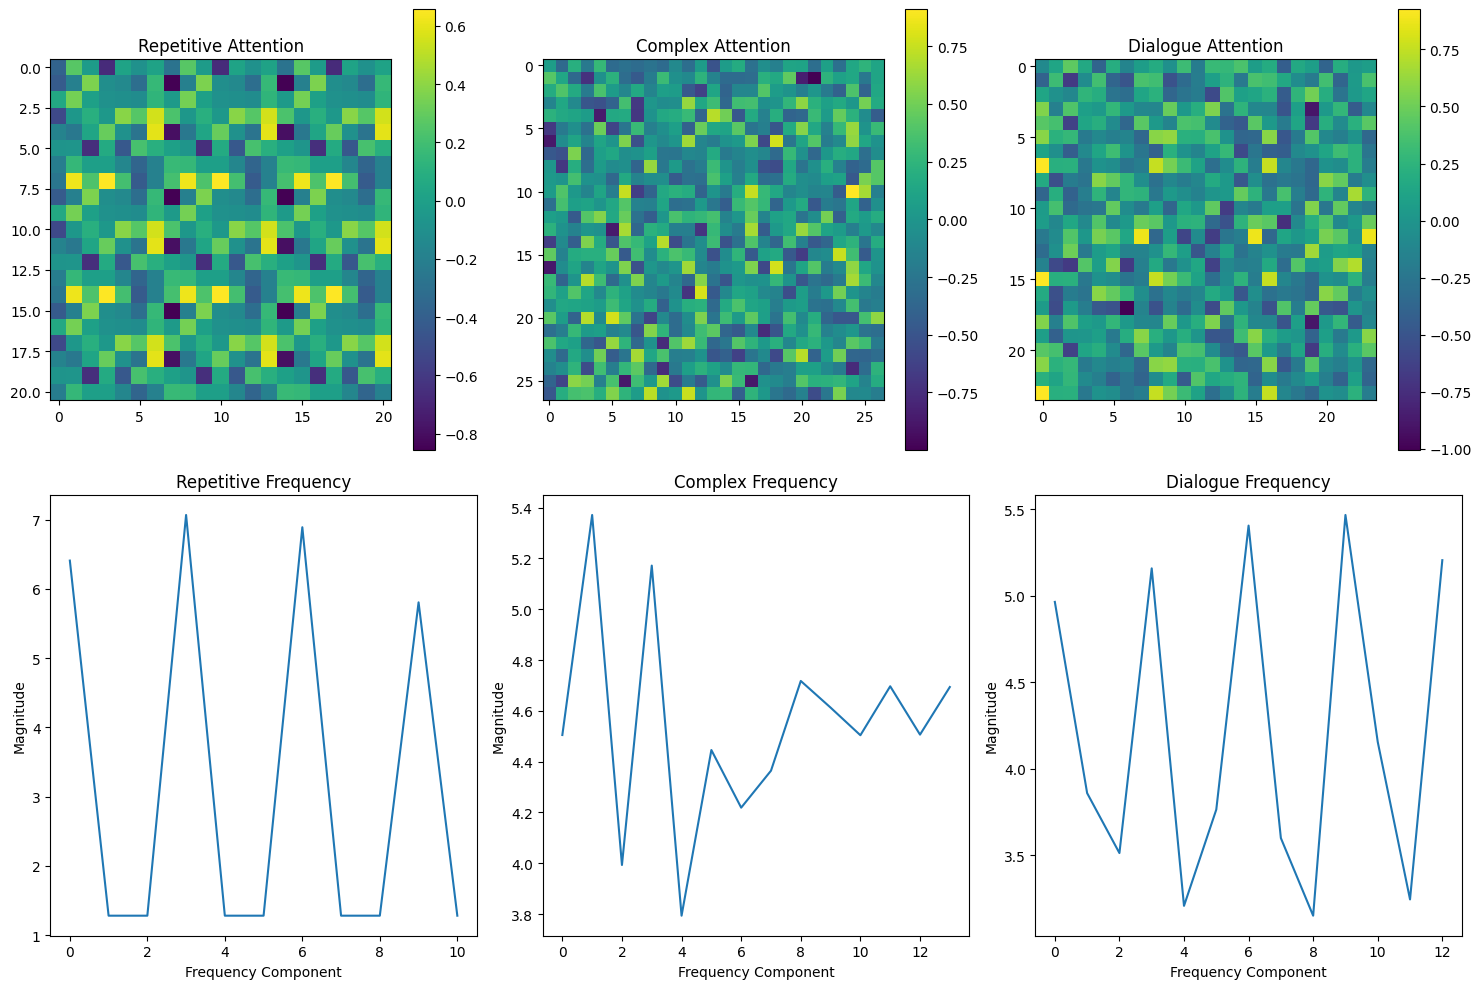


Attention Pattern Analysis:

Repetitive:
Mean attention: -0.0139
Attention std: 0.3080
Max attention: 0.6583

Complex:
Mean attention: -0.0083
Attention std: 0.3326
Max attention: 0.9111

Dialogue:
Mean attention: 0.0128
Attention std: 0.3288
Max attention: 0.9270


In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt

class FrequencyAwareTextAttention(nn.Module):
    def __init__(self, vocab_size=50257, dim=768, block_size=128):
        super().__init__()
        self.dim = dim
        self.block_size = block_size

        # Embedding layers
        self.token_embedding = nn.Embedding(vocab_size, dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, block_size, dim))

        # Frequency-aware attention
        self.qkv = nn.Linear(dim, 3 * dim)
        self.output_norm = nn.LayerNorm(dim)
        self.scale = dim ** -0.5

        # Frequency band analysis
        self.freq_analyzer = nn.Parameter(torch.ones(3))  # low, mid, high bands

    def forward(self, tokens):
        B, N = tokens.shape
        assert N <= self.block_size, "Sequence length exceeds block size"

        # Ensure tokens are long type
        tokens = tokens.long()

        # Get embeddings
        tok_emb = self.token_embedding(tokens)
        pos_emb = self.position_embedding[:, :N, :]
        x = tok_emb + pos_emb

        # QKV projection
        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.dim).permute(2, 0, 1, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Compute attention with frequency awareness
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        # Apply frequency-based modulation
        freq_weights = torch.softmax(self.freq_analyzer, dim=0)
        attn = attn * freq_weights.sum()

        out = torch.matmul(attn, v)
        out = self.output_norm(out)

        return out, attn

def analyze_text_patterns():
    # Initialize tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = FrequencyAwareTextAttention()

    # Test samples with different linguistic patterns
    samples = {
        'repetitive': "The cat sat on the mat. The cat sat on the mat. The cat sat on the mat.",
        'complex': "Quantum entanglement, a phenomenon Einstein famously called 'spooky action at a distance', demonstrates the peculiar nature of quantum mechanics.",
        'dialogue': "'How are you?' he asked. 'I'm fine,' she replied. 'Are you sure?' he questioned.",
    }

    results = {}
    attention_patterns = {}

    for category, text in samples.items():
        # Tokenize and ensure proper tensor type
        tokens = tokenizer(text, return_tensors='pt')['input_ids']

        with torch.no_grad():
            output, attention = model(tokens)

            # Analyze attention pattern
            attention_patterns[category] = attention[0].cpu().numpy()

            # Compute frequency components of the output
            output_fft = torch.fft.rfft(output, dim=1)
            freq_magnitude = torch.abs(output_fft).mean(dim=-1)
            results[category] = freq_magnitude[0].cpu().numpy()

    # Visualize results
    plt.figure(figsize=(15, 10))

    # Plot attention patterns
    for i, (category, attn) in enumerate(attention_patterns.items()):
        plt.subplot(2, 3, i+1)
        plt.imshow(attn, cmap='viridis')
        plt.title(f'{category.capitalize()} Attention')
        plt.colorbar()

    # Plot frequency components
    for i, (category, freq) in enumerate(results.items()):
        plt.subplot(2, 3, i+4)
        plt.plot(freq[:50])  # First 50 frequency components
        plt.title(f'{category.capitalize()} Frequency')
        plt.xlabel('Frequency Component')
        plt.ylabel('Magnitude')

    plt.tight_layout()
    plt.show()

    # Analyze attention statistics
    print("\nAttention Pattern Analysis:")
    for category, attn in attention_patterns.items():
        print(f"\n{category.capitalize()}:")
        print(f"Mean attention: {attn.mean():.4f}")
        print(f"Attention std: {attn.std():.4f}")
        print(f"Max attention: {attn.max():.4f}")

# Run the analysis
analyze_text_patterns()